# Simulation

[[1]](https://github.com/eitcom/pyEIT)

In [1]:
# coding: utf-8
""" demo on forward 2D """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from src.util import plot_mesh

Matplotlib is building the font cache; this may take a moment.


In [2]:
#helper = []
#helper.append()

#helper2 = np.array()


lookup_list = []

**Berechnung der Trjektorien**

In [ ]:
""" 0. build mesh """

n_el = 16  # nb of electrodes
use_customize_shape = False
if use_customize_shape:
    # Mesh shape is specified with fd parameter in the instantiation, e.g : fd=thorax
    mesh_obj = mesh.create(n_el, h0=0.05, fd=thorax)
else:
    mesh_obj = mesh.create(n_el, h0=0.05)
el_pos = mesh_obj.el_pos                    # Elektrodenpositionen extrahieren

# Extrahiert Informationen über das Maschennetz wie Elektrodenpositionen, Knoten und Elemente

pts = mesh_obj.node                         # Knoten extrahieren
tri = mesh_obj.element                      # Elemente extrahieren
x, y = pts[:, 0], pts[:, 1]                 # x- und y-Koordinaten trennen
mesh_obj.print_stats()                      # Netzstatistiken ausgeben
protocol_obj = protocol.create(n_el, dist_exc=4, step_meas=1, parser_meas="std")    # Erstellt ein Messprotokoll mit spezifischen Parametern

#def calculateData (mesh):
 #   protocol_obj = protocol.create(n_el, dist_exc=4, step_meas=1, parser_meas="std")
#    for i in range(len(protocol_obj.ex_mat)):
 #       ex_line = protocol_obj.ex_mat[15].ravel() 
 #       fwd = Forward(mesh)
 #       f = fwd.solve(ex_line)
 #       fwd = EITForward(mesh_obj, protocol_obj)
 #       f = np.real(f)
  #      v = fwd.solve_eit(perm=mesh.perm)   #berechnet den Potentialvektor (192 Werte)
  #  return (f, v)


# Generiert verschiedene Trajektorien-Pfade (Kreis, Blume, Acht, Spirale, Pendel, Ellipse) basierend auf Winkel (a) und Radius (r_path)

def createTrajectory(traj,a,r_path):
    # Erzeugt verschiedene Trajektorien-Pfade basierend auf dem 'traj'-Parameter
    match traj:
            case "circle":
                    center=[np.cos(a)*r_path,np.sin(a)*r_path]
            case "flower":
                    n=4
                    r = np.sqrt(abs(np.cos(n*a)))
                    center=[np.cos(a)*r*r_path,np.sin(a)*r_path*r]
            case "eight":
                    center=[np.sin(a)*r_path,np.sin(2*a)*r_path/2]
            case "spiral":
                    spiral_r = r_path * (a / (4 * np.pi))  # Lineares Wachstum mit dem Winkel
                    center = [spiral_r * np.cos(a), spiral_r * np.sin(a)]
            case "pendel":
                    modified_angle = np.pi/2 * np.sin(a)
                    center = [np.cos(modified_angle) * r_path, np.sin(modified_angle) * r_path]
            case "ellipse":
                    Rotation = True
                    b = r_path
                    c = r_path / 2
                    center = [b*np.cos(a),c*np.sin(a)]
                    if Rotation == True:
                          x = center[0]
                          center[0] = center[1]
                          center[1] = x
                    
    return center

# Berechnet die Vorwärtslösung und EIT-Daten für ein gegebenes Maschennetz.

def calculateData (mesh):
    ex_line = protocol_obj.ex_mat[3].ravel() 
    fwd = Forward(mesh) # Erstellt ein Vorwärtslösungsobjekt für das gegebene Maschennetz. Wird verwendet, um elektrische Felder und Potentiale zu berechnen (im nächsten Schritt)
    f = fwd.solve(ex_line)  # Löst die Vorwärtsproblem für die gewählte Elektrodenanregung. Berechnet die elektrischen Potentiale für das gegebene Maschennetz
    fwd = EITForward(mesh_obj, protocol_obj)
    f= np.real(f) #nur Realteil und eliminiert Imaginärteil
    v = fwd.solve_eit(perm=mesh.perm)   # berechnet Potentialvektor (192 Werte)
    return (f, v)

 #Erstellt die einzelnen Positionen der Anomalie (abhängig von der Anzahl "Nsteps"), Größe der Anomalie über r definierbar, Radius der Kreisbahn mit r_path einstellbar 
def createAnomaly (traj,Nsteps,r,r_path):
    anglePos = np.linspace(0, 2*np.pi, Nsteps)           # P(cos(alpha)=x, sin(alpha)=y)
    perm=100.0
    mesh_new_list = []
    for a in anglePos:
        center = createTrajectory(traj,a,r_path)
        anomaly = PyEITAnomaly_Circle(center, r=r, perm=perm)
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
        f, v = calculateData(anomaly_mesh)
        mesh_dict = {"mesh": anomaly_mesh, "x":center[0], "y":center[1], "radius":r, "perm_init":perm, "f":f, "v":v, "anomaly": anomaly}
        mesh_new_list.append(mesh_dict) #erstellt eine Liste aus den Mesh-Dict Daten
        #perm = mesh_new.perm    
    return mesh_new_list


2D mesh status:
1476 nodes, 2821 elements


**Erstellt Plot der Trajektorie**

In [4]:
def checkTraj(mesh_new_list, Nstep):
    
    plt.figure(figsize=(10, 10))
    
    pts = mesh_new_list[0]["mesh"].node
    tri = mesh_new_list[0]["mesh"].element
    
    plt.triplot(pts[:, 0], pts[:, 1], tri, color='gray', alpha=0.5)
    
    x_coords = [mesh_dict["x"] for mesh_dict in mesh_new_list]
    y_coords = [mesh_dict["y"] for mesh_dict in mesh_new_list]
    
    plt.plot(x_coords, y_coords, '-', color='blue', alpha=0.6, 
             label='Trajektorie', linewidth=2)
    
    # Plottet die Anomalie-Positionen
    num_images = Nstep
    step_size = max(Nstep // num_images, 1)  # Schrittgröße, mindestens 1

    # Berechne die Indizes, die für die Bilder verwendet werden
    indices = np.linspace(0, Nstep - 1, num_images, dtype=int)

    for i in indices:
        plt.plot(x_coords[i], y_coords[i], 'ro', markersize=6)
        
        circle = Circle((x_coords[i], y_coords[i]), 
                       radius=mesh_new_list[i]["radius"],
                       fill=False, 
                       color='red',
                       alpha=0.3)
        plt.gca().add_patch(circle)
    
    if hasattr(mesh_new_list[0]["mesh"], 'el_pos'):
        el_pos = mesh_new_list[0]["mesh"].el_pos
        plt.plot(pts[el_pos, 0], pts[el_pos, 1], 'ko', 
                markersize=6, label='Elektroden')
    
    plt.axis('equal')
    
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.title('EIT Mesh mit Anomalie-Trajektorie')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    

**Erstellt Gif-Animation**

In [5]:
def createAnimation(traj,mesh_new_list, protocol_obj, output_gif="animation_with_movement.gif"):
    
    image_files = []
    output_gif = f"animation_{traj}.gif"
    # Loop durch jede Anomalie-Position
    center_coords = []
    for i, mesh_data in enumerate(mesh_new_list):
        center_coords.append([mesh_data["x"], mesh_data["y"]])
        # Loop durch jedes Elektrodenpaar für die aktuelle Anomalie-Position
        for j, ex_line in enumerate(protocol_obj.ex_mat):
            fig, ax1 = plt.subplots(figsize=(9, 6))

            # Potentialverteilung für dieses Elektrodenpaar
            fwd = Forward(mesh_data["mesh"])
            f = np.real(fwd.solve(ex_line.ravel()))

            # Äquipotentiallinien basierend auf der Einspeisung
            vf = np.linspace(min(f), max(f), 64)
            ax1.tricontour(x, y, tri, f, vf, cmap=plt.cm.viridis)

            ax1.tripcolor(
                x,
                y,
                tri,
                np.real(mesh_data["mesh"].perm),
                edgecolors="k",
                shading="flat",
                alpha=0.5,
                cmap=plt.cm.Greys,
            )

            # plottet Elektroden
            ax1.plot(x[el_pos], y[el_pos], "ro")
            for e_idx, e in enumerate(el_pos):
                ax1.text(x[e], y[e], str(e_idx + 1), size=12)
                
            center_x = [coord[0] for coord in center_coords]
            center_y = [coord[1] for coord in center_coords]
            ax1.plot(center_x, center_y, marker='o', color='b', label="Trajectory Path")

            # Plotte das Zentrum der aktuellen Anomalie
            ax1.scatter(mesh_data["x"], mesh_data["y"], color="r", label="Anomaly Center")
            ax1.set_title(f"Trajectory-Path:{ traj}, Injection Electrode-Pair: [{ex_line[0]};{ex_line[1]}]")
            ax1.set_aspect("equal")
            ax1.set_ylim([-1.2, 1.2])
            ax1.set_xlim([-1.2, 1.2])
            fig.set_size_inches(6, 6)

            # Speichert das Bild
            filename = f"frame_{i}_{j}.png"
            plt.savefig(filename)
            image_files.append(filename)
            plt.close(fig)

    # Erstellt das GIF
    frames = [Image.open(image) for image in image_files]
    frames[0].save(output_gif, format="GIF", append_images=frames[1:], save_all=True, duration=100, loop=0)

    # Einzelbilder löschen
    for image in image_files:
        os.remove(image)

In [6]:
def generateData (traj,Nstep,r_anomaly,r_path, lookup_list):

    mesh_new_list = createAnomaly(traj, Nstep, r_anomaly, r_path)

## Speicherung der Daten in einem Data-Folder

    # base_name = "data"

    # counter = 1
    # folder_name = base_name
    # while os.path.exists(folder_name):
    #     folder_name = f"{base_name}{counter}"
    #     counter += 1

    # os.makedirs(folder_name) 

    # for i in range(len(mesh_new_list)):
    #     file_path = os.path.join(folder_name, f"sample_{i:06d}.npz")  
    #     np.savez(file_path, v=mesh_new_list[i]["v"], anomaly=mesh_new_list[i]["anomaly"])
    
    # lookup = {
    #     "folder": folder_name,
    #     "Nstep": Nstep,
    #     "r_anomaly": r_anomaly,
    #     "r_path": r_path,
    # }
    # lookup_list.append(lookup)

## Visualisierung der Trajektorie (einzelne Bilder)
    checkTraj(mesh_new_list,Nstep)

## Visualisierung der Trajektorie als gif
  
    # createAnimation(traj,mesh_new_list,protocol_obj)   #Erstellt ein Gif von der simulierten Trajektorie (kann ich für die Verteidigung verwenden)
    return lookup_list

**RUN Simulation**

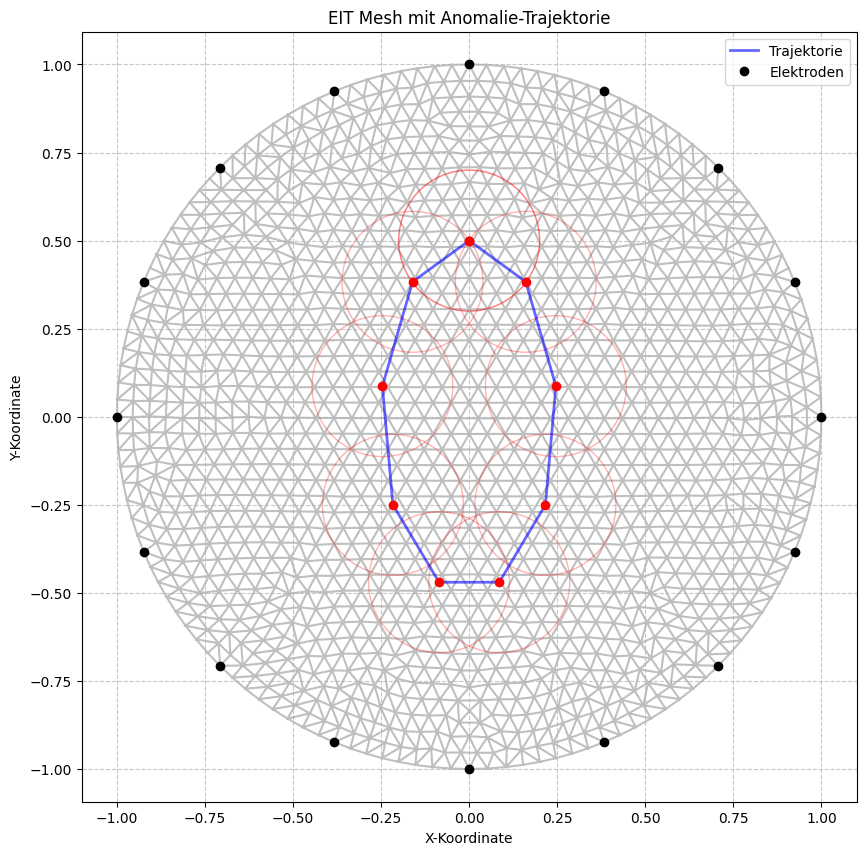

In [7]:
Nstep = 10                        # Anzahl der Steps
r_anomaly = 0.2                     # Radius der Anomaly
r_path = 0.5                        # Radius der Kreisbahn 
traj = "ellipse"

lookup_list = generateData(traj,Nstep,r_anomaly,r_path,lookup_list)

# print(lookup_list)

#TODO: neue Trajektorien einbauen
#TODO: load Funktion einbauen

**Load Data**

In [8]:
from glob import glob

In [9]:
def loadData():
    file_list = []

    data_dirs = glob("data*/")

    for directory in data_dirs:
        file_list.extend(glob(f"{directory}*.npz"))
    
    file_list = np.sort(file_list)

    print(file_list)
    
    V = list()  # voltages
    A = list()  # anomalies
    for file in file_list:
        tmp = np.load(file, allow_pickle=True)
        V.append(tmp["v"])
        A.append(tmp["anomaly"].tolist())
    
    return V,A

In [10]:
V,A = loadData()

[]


In [11]:
A

[]

In [12]:
V

[]